In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase

In [3]:
include("./Data_Input.jl")
using .DataImport

include("./Distributions.jl")
using .MakeDistributions

include("./Plots.jl")
using .Plots

In [4]:
sep_data = DataImport.GetCrossSecData("./Data/crosssecdata.RData"; min_samples=3e1, min_counts=1, min_nreads=1e4);

 `sep_data` contains 14 possible environments: `SEAWATER`, `ORAL`, `GUT`, `VAGINAL`, `SOIL`, `ORALCAVITY`, `FECES`, `SKIN`, `GLACIER`, `AQUA1`, `RIVER`, `LAKE`, `AQUA2`, `SLUDGE`.\
 Then each environment consists of a dataset stored in a dataFrame with the following features:\
 **project_id**: identifies projects\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run

In [5]:
AFDs = []
TAYLORs = []
MADs = []

cutoffs = Dict("SLUDGE" => -18.8, "LAKE" => -17.0, "RIVER" => -17.5, "GUT" => -17.5, "GLACIER" => -16.25, "SEAWATER" => -17.9,
    "SOIL" => -14.25, "ORAL" => -16.1, "VAGINAL" => -Inf, "FECES" => -Inf, "AQUA1" => -Inf, "AQUA2" => -Inf, "ORALCAVITY" => -Inf, "SKIN" => -Inf)

for (key, data) in sep_data

    data.f = data.count ./ data.nreads # I can do this because there is only one sample with one run per day

    otus = unique(data.otu_id)
    runs = unique(data.run_id)
    otu_groups = groupby(data, :otu_id)

    if length(otus) < 1e1
        println("Skipping $key")
        continue
    end
    println(key)
    y = zeros(length(runs), length(otus))
    env_data = []
    otu_index = Dict(otu => i for (i, otu) in enumerate(otus))
    run_index = Dict(run => i for (i, run) in enumerate(runs))

    for g in otu_groups
        otu = g.otu_id[1]
        i = otu_index[otu]
        for (run, fval) in zip(g.run_id, g.f)
            j = run_index[run]
            y[j, i] = fval
        end

        y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
        push!(env_data, y[:,i])
    end

    matrix_data = hcat(env_data...)
    
    afd = MakeDistributions.make_AFD(matrix_data; Δb=0.5, env="$key")
    push!(AFDs, afd)

    taylor = MakeDistributions.make_Taylor(matrix_data; Δb=0.5, env="$key")
    push!(TAYLORs, taylor)

    mad = MakeDistributions.make_MAD(matrix_data; c=exp(cutoffs[key]), Δb=0.5, env="$key")
    push!(MADs, mad)
end

SEAWATER
RIVER
ORAL
Skipping ORALCAVITY
GUT
Skipping AQUA1
GLACIER
SLUDGE
LAKE
SOIL
Skipping VAGINAL
Skipping AQUA2
Skipping FECES
Skipping SKIN


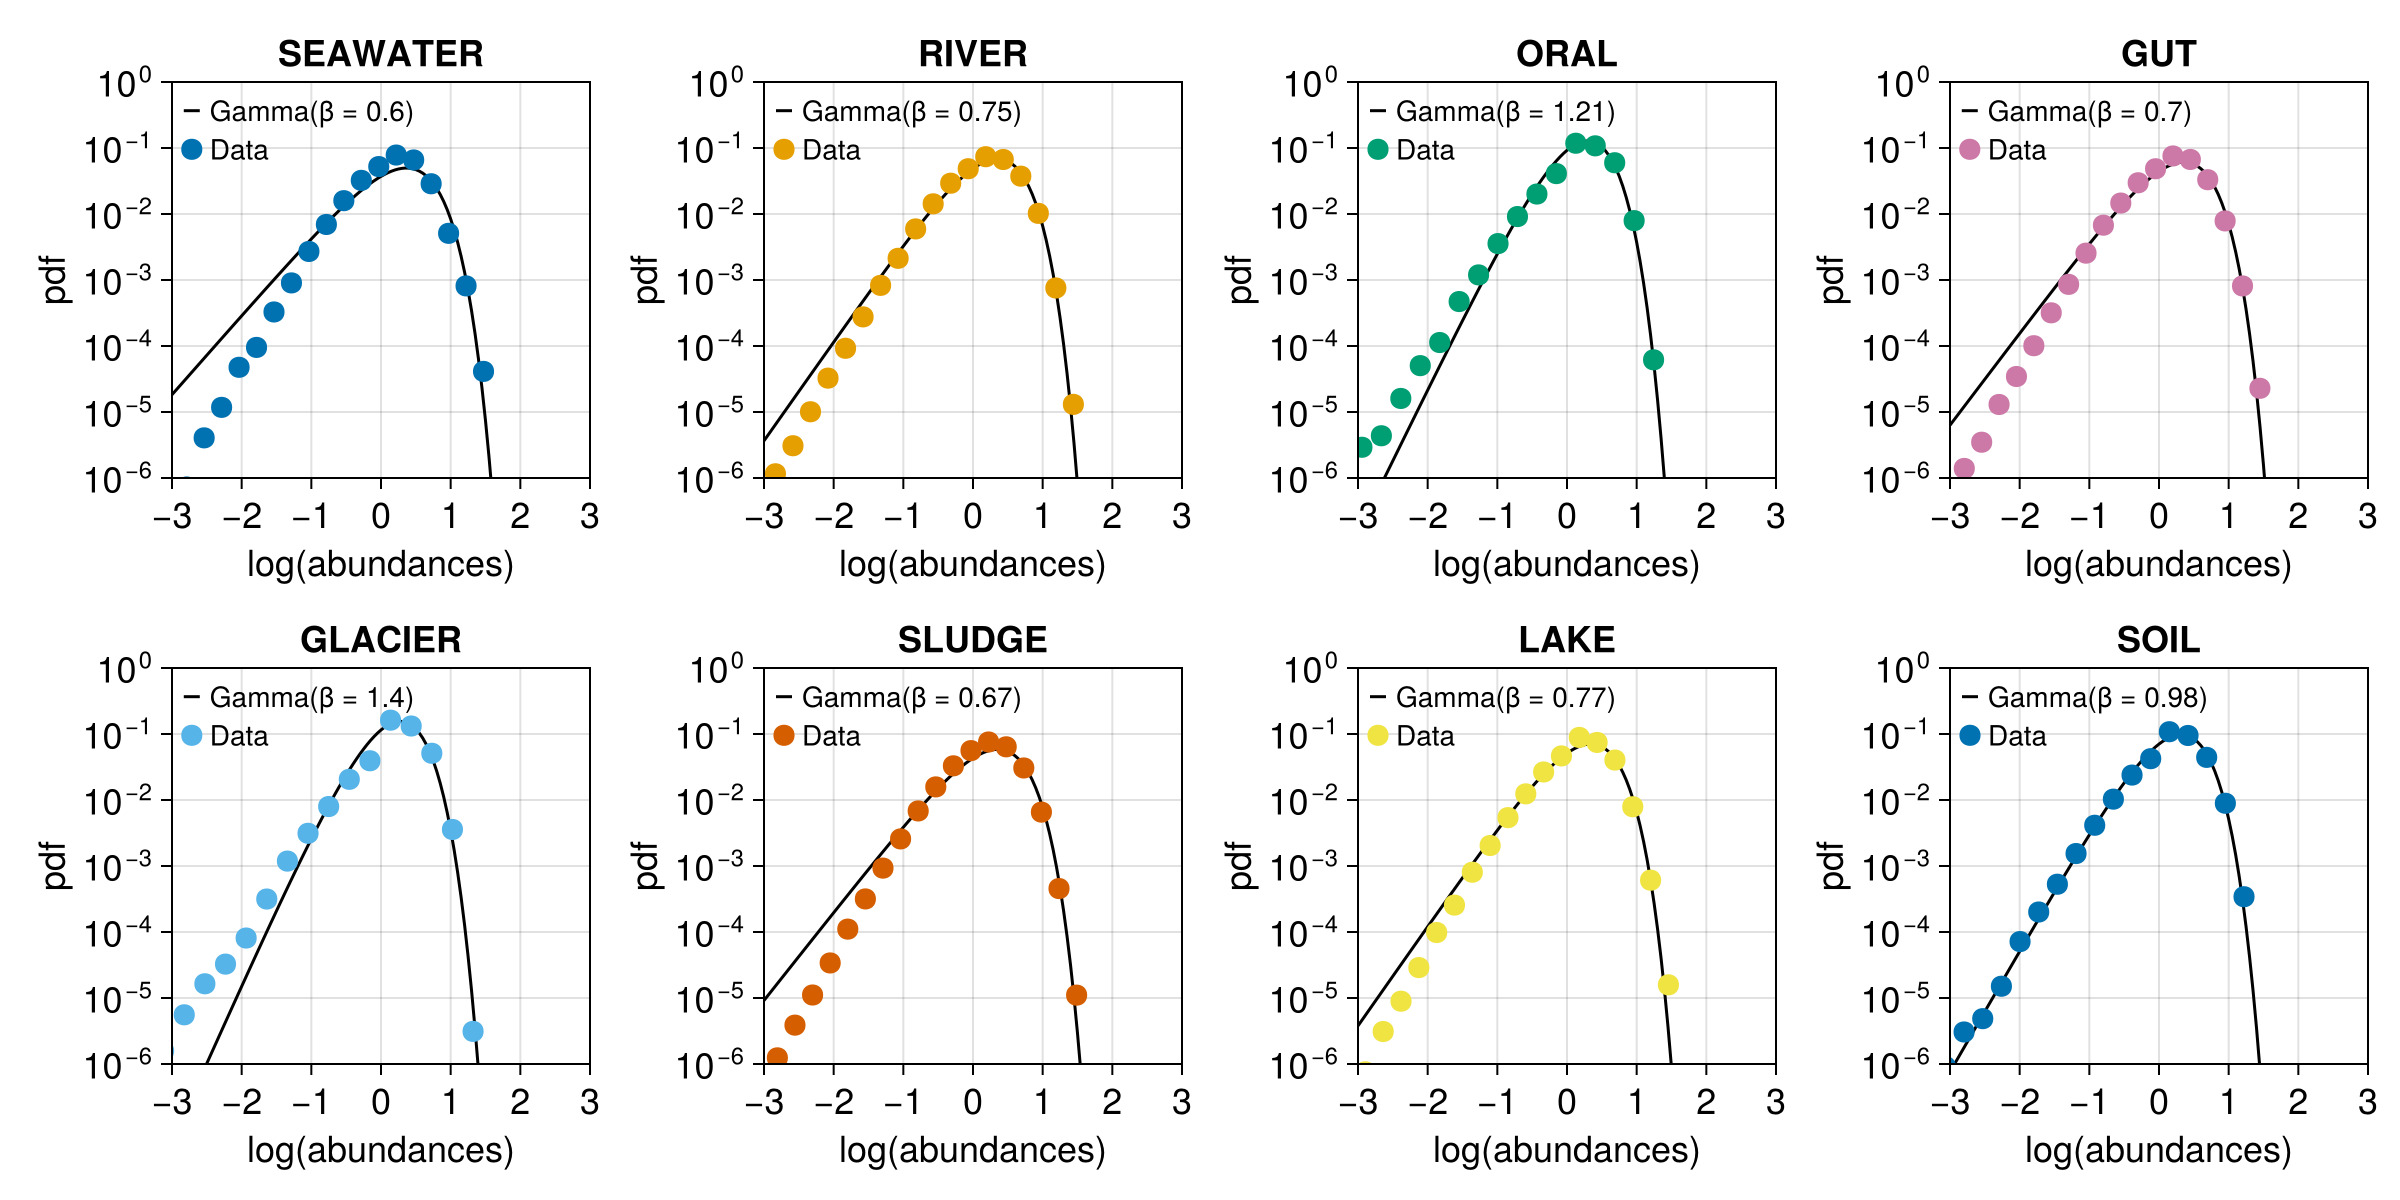

CairoMakie.Screen{IMAGE}


In [6]:
fig = Plots.combine_AFD_histograms(AFDs, nrows=2, ncols=4, savepath=nothing)
display(fig)

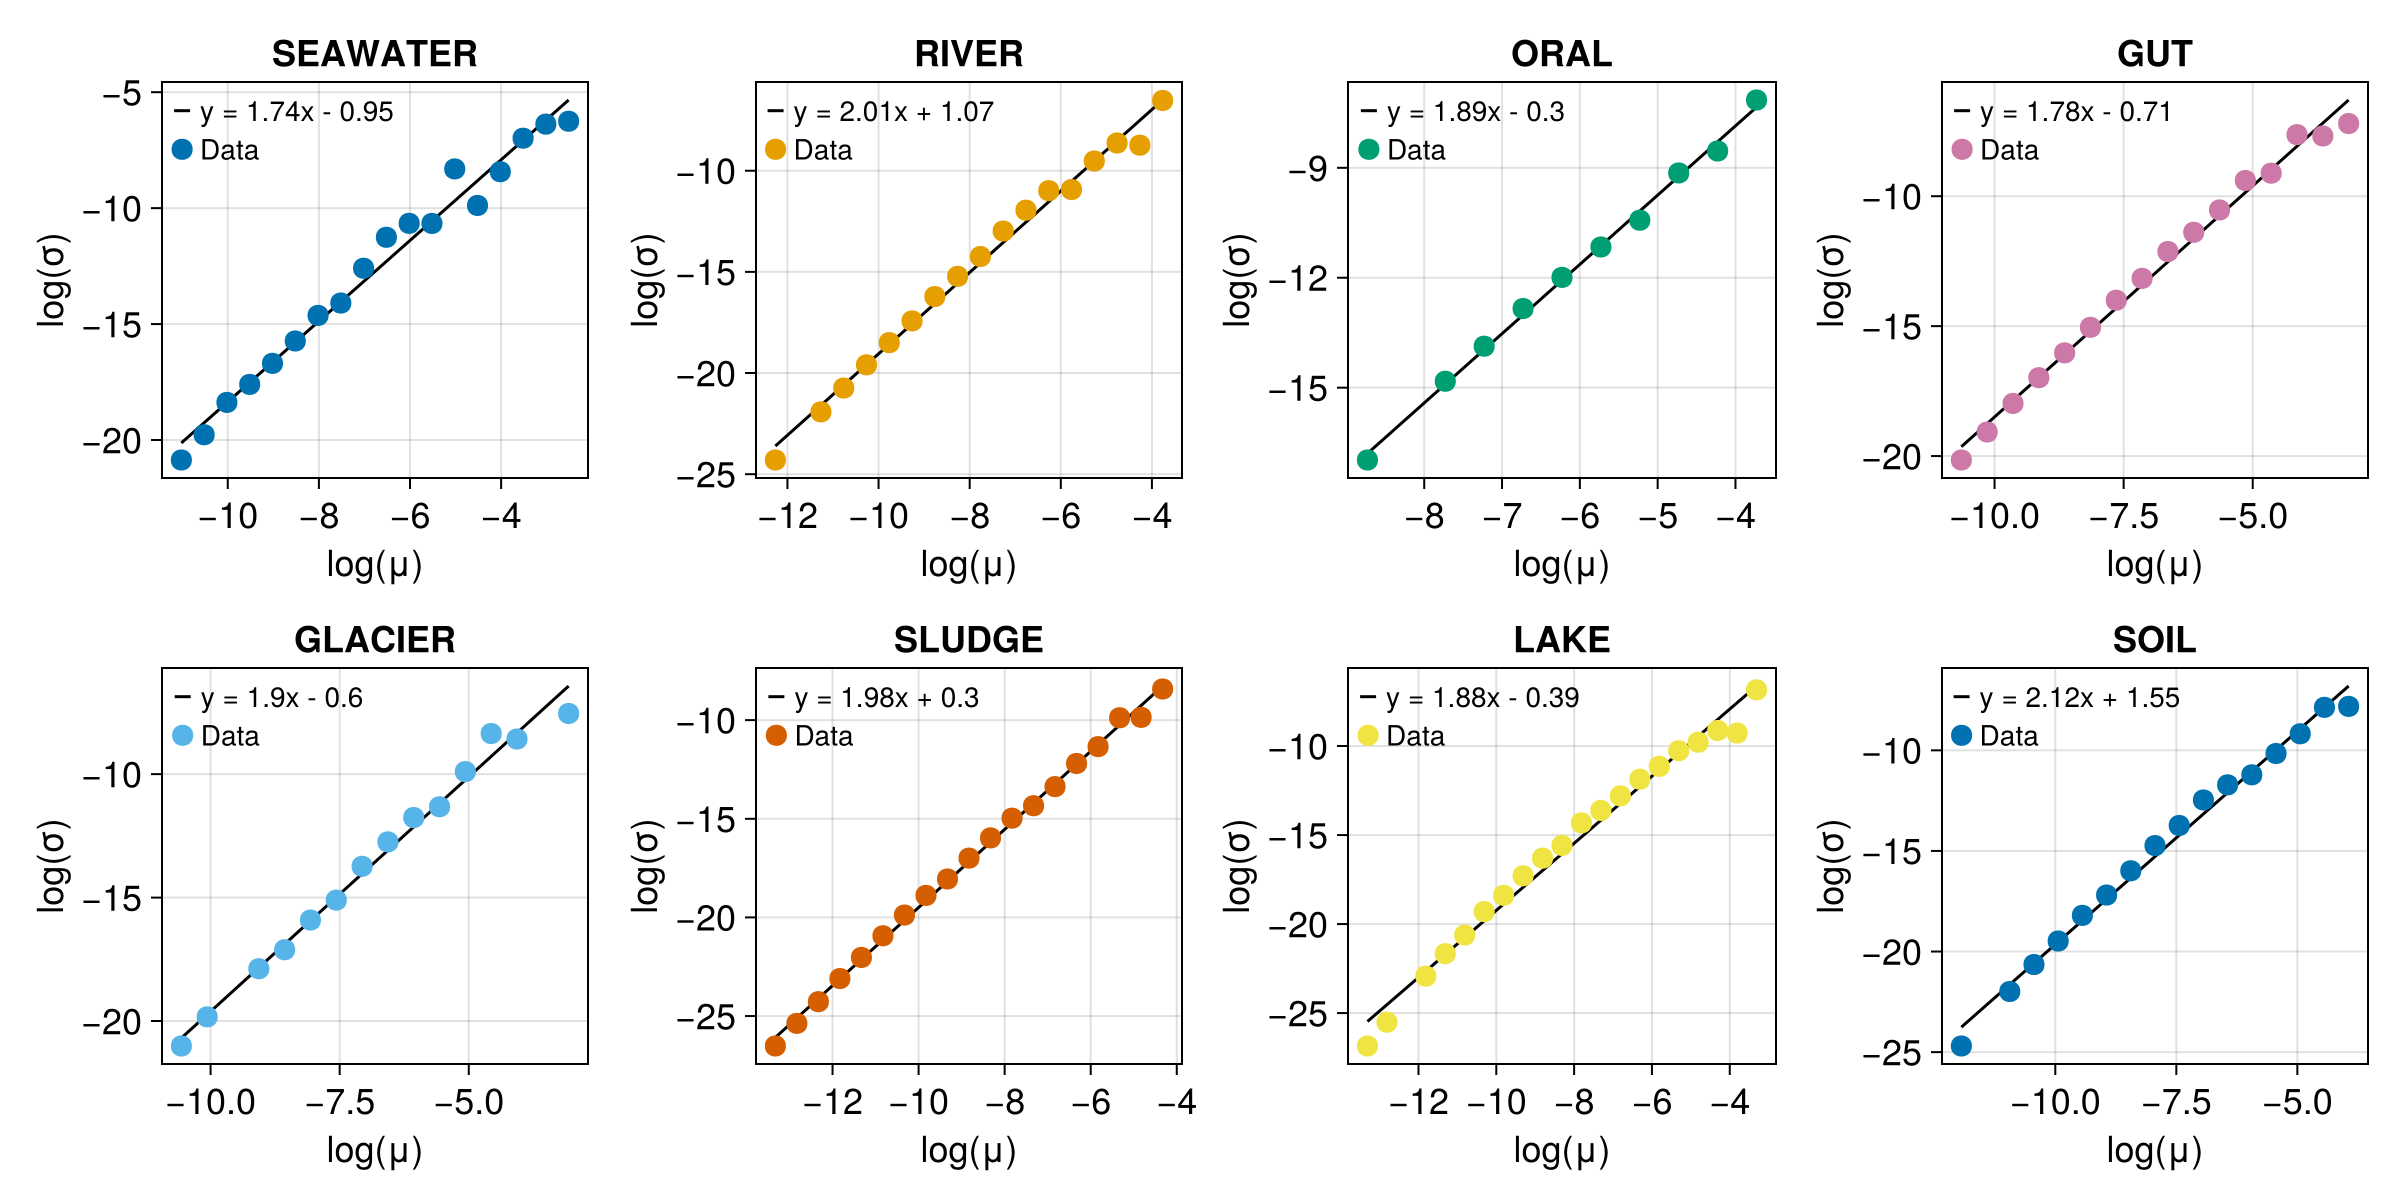

CairoMakie.Screen{IMAGE}


In [7]:
fig = Plots.combine_Taylor_histograms(TAYLORs, nrows=2, ncols=4, savepath=nothing)
display(fig)

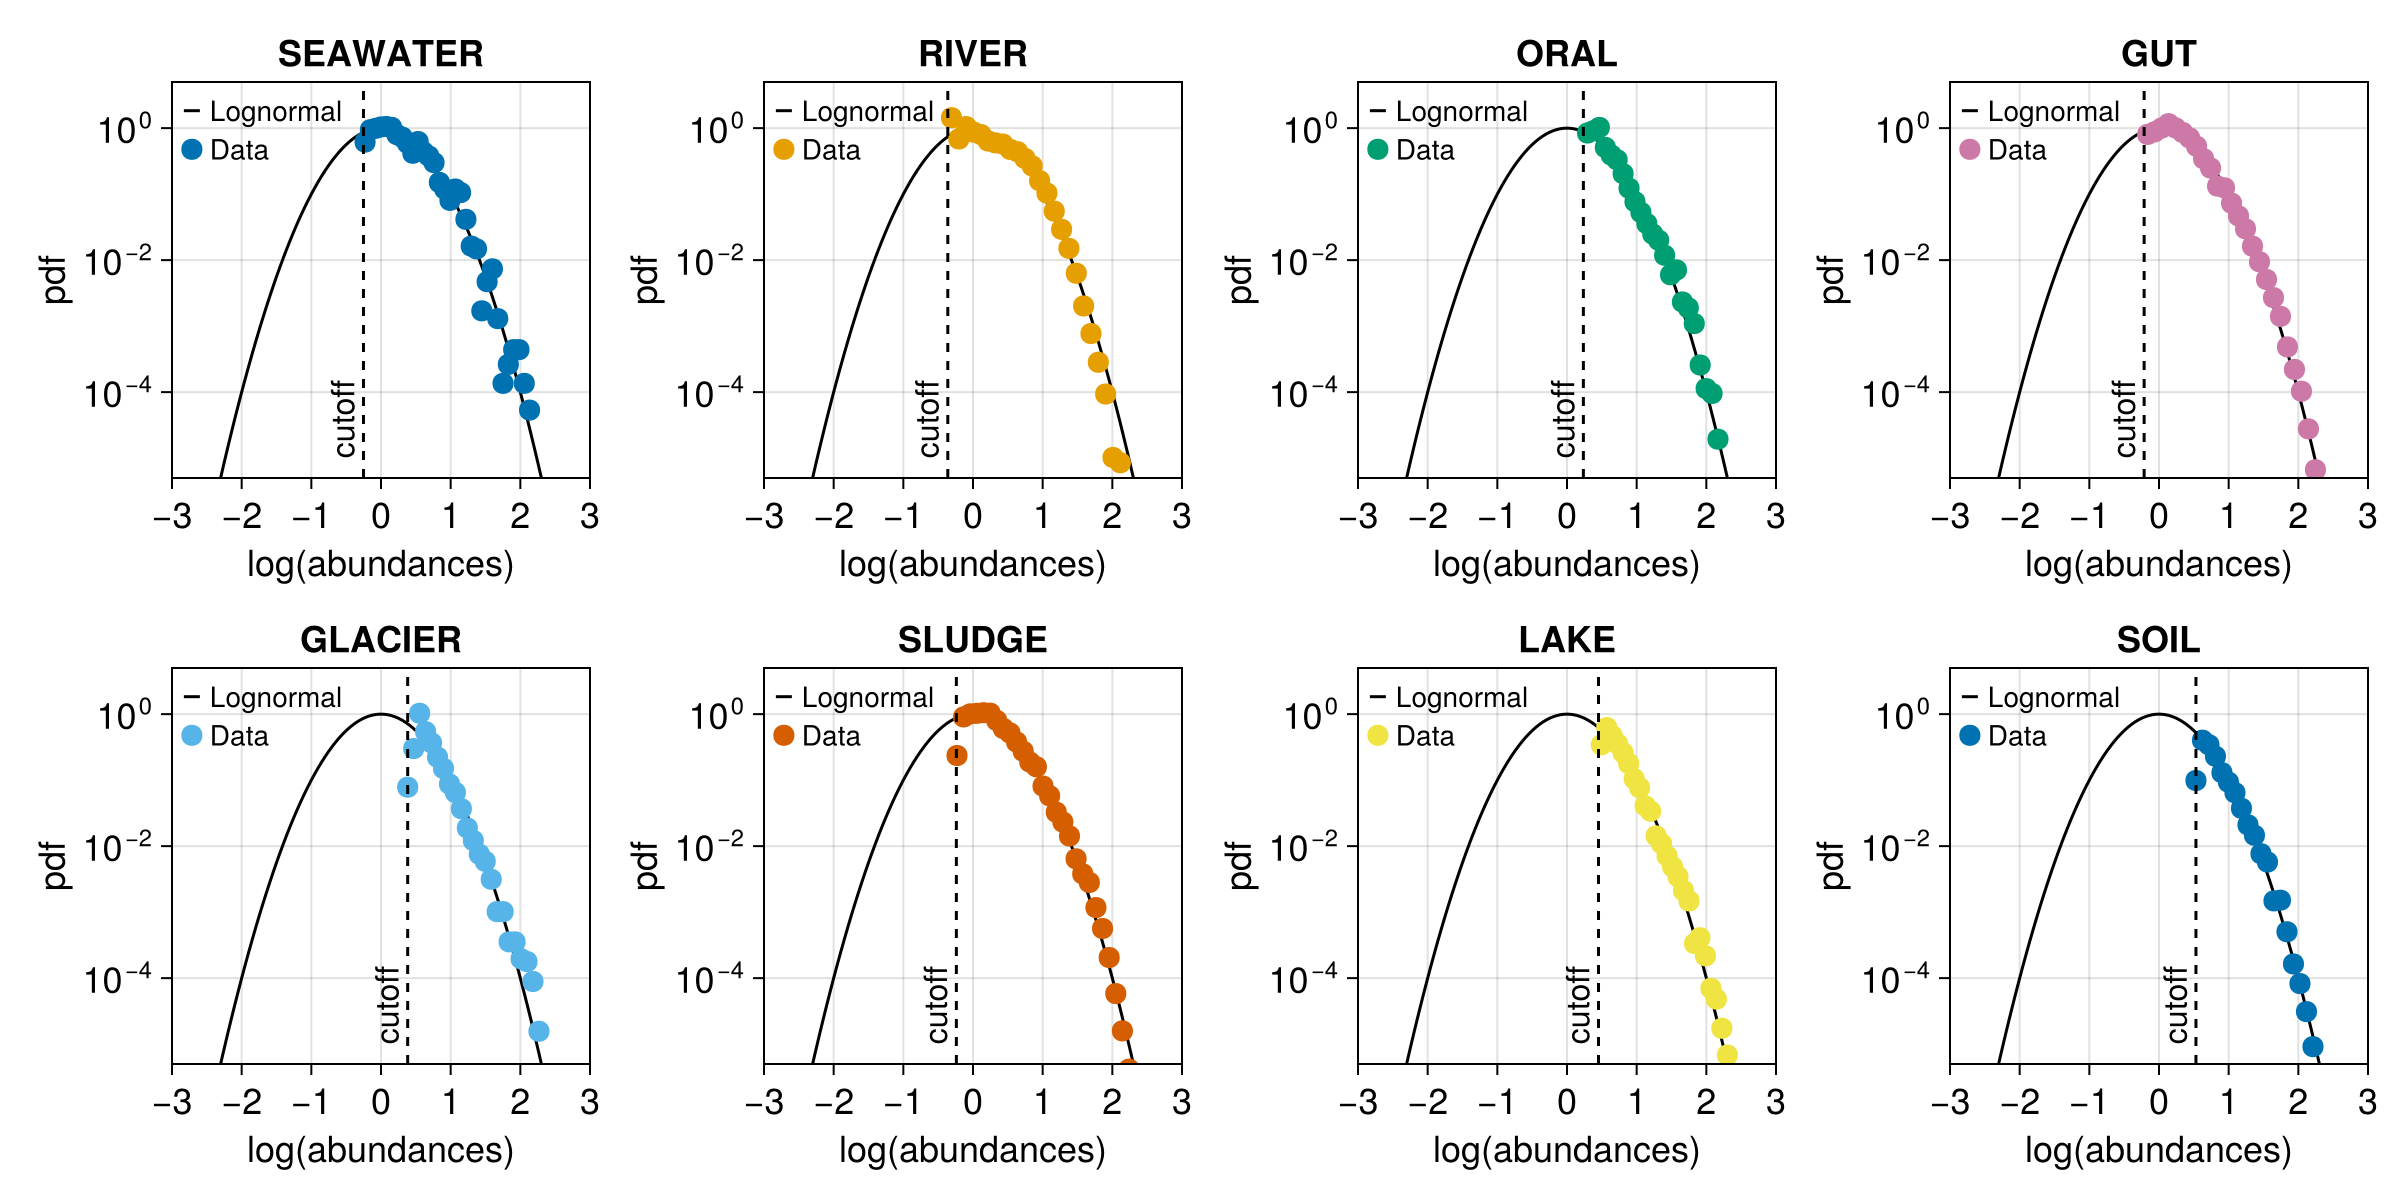

CairoMakie.Screen{IMAGE}


In [8]:
fig = Plots.combine_MAD_histograms(MADs, nrows=2, ncols=4, savepath=nothing)
display(fig)